<a href="https://colab.research.google.com/github/pablohd10/P2.1-RRNN/blob/main/P2.1_RRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

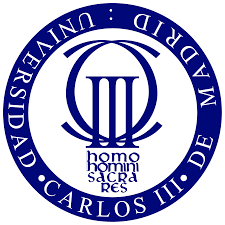


# PRÁCTICA 2.1: REDES DE NEURONAS
---

Autores: Pablo Hidalgo Delgado y Marcos Caballero Cortés   

NIAs: 100451225 y 100451047


# PREGUNTAS PROFE

- Recall, f1-score, matriz de confusion... solo para el modelo final??? Entonces como podemos saber si el balanceo ha hecho su función??

- Modelo final: Para este modelo hay que entrenarlo al máximo por lo que
técnicas como el early stopping no tienen sentido. Entonces con qué número de épocas lo entrenamos? el numero de epocas en que se haya parado con el early stopping?







## 1. Introducción
El propósito de esta práctica de clasificación clásico haciendo uso del Perceptrón Multicapa (PM).

Para ello, se nos dispone de un conjunto de datos desbalanceados de trayectorias de diferentes individuos
en diferentes medios de transporte.

Utilizando estos datos, debemos generar un modelo capaz de clasificar el medio de transporte en el que se desplaza un individuo.




## 2. Leer los conjuntos de datos


En primer lugar, importamos todas las librerías que se van a utilizar a lo largo de la práctica

In [2]:
import random
import time
import pickle
import seaborn as sns


import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.table import table

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping



Leemos el conjunto de datos proporcionado.

In [3]:
archivo_csv = 'dataRRNN2.csv'

datos = pd.DataFrame()

# Leemos el archivo
datos = pd.read_csv(archivo_csv)

## 3. Análisis Exploratorio de Datos (EDA)
Antes de empezar con la división en datos de entrenamiento y test, vamos a realizar un pequeño análisis exploratorio de datos (EDA). De esta manera, podremos investigar y resumir las características más importantes de nuestro dataset. Esto nos servirá para comprender mejor los datos y optimizar la obtención de nuestro modelo.


### 3.1 Información básica

In [4]:
datos.info(memory_usage = 'deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29151 entries, 0 to 29150
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    29151 non-null  float64
 1   track_id                   29151 non-null  float64
 2   mean_delta_times           29151 non-null  float64
 3   std_delta_times            29151 non-null  float64
 4   mean_hours                 29151 non-null  float64
 5   std_hours                  29151 non-null  float64
 6   mean_distances             29151 non-null  float64
 7   std_distances              29151 non-null  float64
 8   mean_velocities            29151 non-null  float64
 9   std_velocities             29151 non-null  float64
 10  mean_accelerations         29151 non-null  float64
 11  std_accelerations          29151 non-null  float64
 12  mean_headings              29151 non-null  float64
 13  std_headings               29151 non-null  flo

El conjunto de datos se compone de 29151 instancias y 22 atributos de tipo float64. La variable de salida, label, es de tipo int64.

También podemos observar que no existen columnas que contengan valores nulos.

### 3.2 Atributos irrelevantes
En el apartado anterior identificamos las columnas user_id y track_id que parecen ser identificadores. Lo comprobamos por si acaso.


In [5]:
print(datos.head(5))

   user_id      track_id  mean_delta_times  std_delta_times  mean_hours  \
0     52.0  2.008071e+13          4.954975         0.304779         4.0   
1     52.0  2.008071e+13          4.890226         1.373293         4.0   
2    167.0  2.008081e+13          2.000000         0.000000         1.0   
3    167.0  2.008081e+13          2.000000         0.000000         1.0   
4    167.0  2.008081e+13          2.000000         0.000000         1.0   

   std_hours  mean_distances  std_distances  mean_velocities  std_velocities  \
0        0.0        7.370991       2.830568         1.475115        0.564191   
1        0.0        4.358587       3.252789         0.833067        0.604174   
2        0.0        2.298434       1.164979         1.149217        0.582489   
3        0.0        2.135659       0.579179         1.067830        0.289589   
4        0.0        0.321824       0.596578         0.160912        0.298289   

   ...  std_headings  mean_heading_changes  std_heading_changes  \
0

Efectivamente, como podíamos intuir, se trata de indentificadores.

Los identificadores no aportan información predictiva para el modelo. Además, podrían introducir un sesgo e información de la que deberíamos prescindir ya que se podría producir sobreajuste.

Por estas razones, eliminamos este atributo de nuestro conjunto de datos sin que exista riesgo de fuga de información.

In [6]:
datos.drop(['user_id', 'track_id'], axis=1, inplace=True)

### 3.2 Atributos compuestos de valores constantes

A continuación, vamos a analizar si existen columnas constantes en nuestro conjunto de datos. En ese caso, podremos eliminarlas de nuestro dataset ya que no aportan ninguna información a la variable de respuesta y no existe riesgo de information leakage.

In [7]:
# Eliminamos las columnas con solo un valor único
columnas_constantes = []
for col in datos.columns:
    if datos[col].nunique() == 1:
        print(col)
        columnas_constantes.append(col)
if len(columnas_constantes) == 0:
  print("No existen atributos con valores constantes")

No existen atributos con valores constantes


### 3.3 Distribución de clases
Aunque el enunciado ya indica que los datos presentan desbalanceo, es fundamental confirmar esta característica, así como observar la distribución de las clases.

0    10899
1     5543
2     6558
3     4403
4     1748
Name: label, dtype: int64


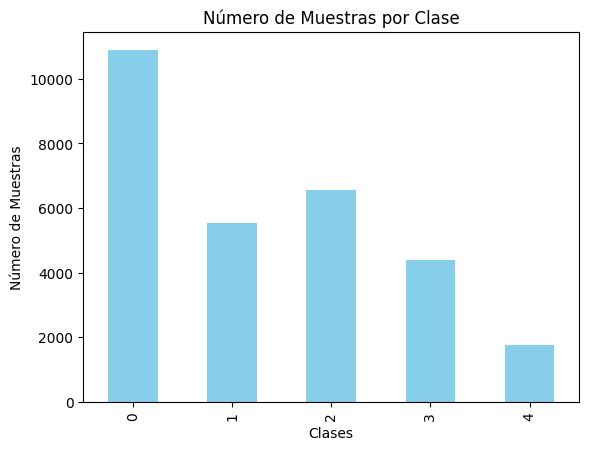

In [8]:
# Calculamos el recuento de muestras por clase y ordenamos por índice (las clases)
conteo_clases = datos['label'].value_counts().sort_index()

# Creamos la gráfica de barras
conteo_clases.plot(kind='bar', color='skyblue')
print(conteo_clases)
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Número de Muestras por Clase')
plt.show()

Vemos el claro desbalanceo de los datos teniendo la clase 0 (andando) bastante más muestras que la clase 4 (en metro).

## 5. Preproceso
Previamente a entrenar los modelos, debemos realizar una transformación de los datos para que puedan ser interpretados por el algoritmo de manera eficiente. Las transformaciones de datos que realizamos son las siguientes:

### 5.1 División de datos en train, validation y test.
Una vez explorado y analizado nuestro conjunto de datos, dividimos el dataset en conjuntos de entrenamiento (train), prueba (test) y validación (validation). Para ello, utilizamos la función train_test_split de la librería sklearn.

Dividimos los datos en 2/3 para train y 1/3 para test. El conjunto de validación se corresponderá con un 20% del conjunto de entrenamiento tal y como se nos pide en el enunciado de la práctica.

Antes de realizar la división, debemos separar la variable de respuesta del resto del conjunto de datos.

In [9]:
X = datos.drop("label", axis = 1)
y = datos["label"]

Dividimos el conjunto de datos. Lo hacemos especificando el parámetro suffle = True para que se aleatorizen los datos y el resultado sea reproducible.

Además, al tratarse de un problema desbalanceado, utilizamos el parámetro stratify para realizar una partición estratificada, es decir, mantener la misma proporción de clases en ambos conjuntos.

También especificamos la semilla random_state a 40 para que los resultados sean reproducibles.



In [10]:
# Dividimos los datos originales en conjuntos de entrenamiento (2/3) y prueba (1/3%)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y, test_size=1/3, random_state=40, shuffle = True, stratify=y)

# Dividimos el conjunto de entrenamiento en conjuntos de entrenamiento (80%) y validación (20%)
X_train_raw, X_validation_raw, y_train_raw, y_validation_raw = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=40, shuffle = True, stratify=y_train_raw)

# Guardamos los conjuntos de datos en archivos CSV
X_train_raw.to_csv('X_train_raw.csv', index=False)
y_train_raw.to_csv('y_train_raw.csv', index=False)
X_validation_raw.to_csv('X_validation_raw.csv', index=False)
y_validation_raw.to_csv('y_validation_raw.csv', index=False)
X_test_raw.to_csv('X_test_raw.csv', index=False)
y_test_raw.to_csv('y_test_raw.csv', index=False)

Verificamos que existen muestras de cada clase en cada conjunto de datos. Se deberá obtener la misma proporción que se obtuvo con el conjunto de datos entero.

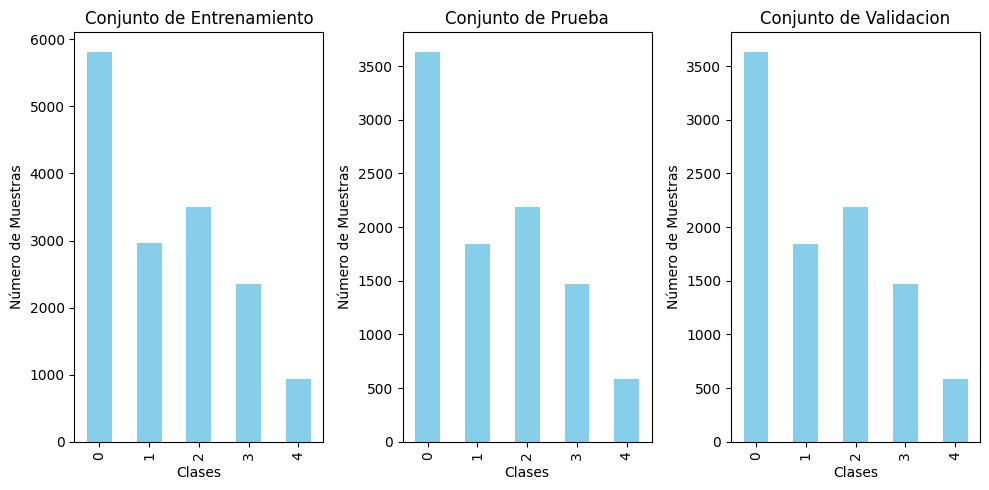

In [11]:
# Verificamos el balance de clases en los conjuntos de entrenamiento, prueba y validación
conteo_clases_train = y_train_raw.value_counts().sort_index()
conteo_clases_test = y_test_raw.value_counts().sort_index()
conteo_clases_validation = y_validation_raw.value_counts().sort_index()

# Creamos la gráfica de barras para los conjuntos de entrenamiento y prueba
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
conteo_clases_train.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Entrenamiento')

plt.subplot(1, 3, 2)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Prueba')


plt.subplot(1, 3, 3)
conteo_clases_test.plot(kind='bar', color='skyblue')
plt.xlabel('Clases')
plt.ylabel('Número de Muestras')
plt.title('Conjunto de Validacion')

plt.tight_layout()
plt.show()

### 5.3 Codificación de la variable de salida
Al estar frente a un problema de clasificación multiclase (5 clases distintas) es importante codificar estos valores para asegurar la compatibilidad con los algoritmos de aprendizaje automático. Para ello, utilizamos la clase LabelBinarizer de scikit learn.

In [12]:
print(y_train_raw)
# Binarizamos la variable de salida usando LabelBinarizer
label_binarizer = LabelBinarizer()

# Binarizamos y_train
y_train_binarized = label_binarizer.fit_transform(y_train_raw)

# Binarizamos y_validation
y_validation_binarized = label_binarizer.transform(y_validation_raw)

# Binarizamos y_test
y_test_binarized = label_binarizer.transform(y_test_raw)

25688    0
22960    0
12721    3
4071     1
708      2
        ..
1535     0
20962    0
10501    3
27156    2
4968     3
Name: label, Length: 15547, dtype: int64


### 5.1 Normalización
Para que no se produzca information leakage y no dar información al conjunto de test, normalizamos todos los datos con el mínimo y máximo obtenido del conjunto de entrenamiento.

In [13]:
X_train = X_train_raw
X_validation = X_validation_raw
X_test = X_test_raw

for columna in X_train_raw:
 # Obtenemos el minimo y el maximo de cada columna del conjunto de train
  min = X_train_raw[columna].min()
  max = X_train_raw[columna].max()
  # Conjunto de entrenamiento
  X_train[columna] = (X_train_raw[columna] - min)/(max - min)
  # Conjunto de validación
  X_validation[columna] = (X_validation_raw[columna] - min)/(max - min)
  # Conjunto de test
  X_test[columna] = (X_test_raw[columna] - min)/(max - min)

y_min = y_train_binarized.min()
y_max = y_train_binarized.max()
# Conjunto de entrenamiento
y_train = (y_train_binarized - y_min)/(y_max - y_min)
# Conjunto de validación
y_validation = (y_validation_binarized - y_min)/(y_max - y_min)
# Conjunto de test
y_test = (y_test_binarized - y_min)/(y_max - y_min)

# Guardamos los conjuntos de datos en archivos CSV
X_train.to_csv('X_train.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
X_validation.to_csv('X_validation.csv', index=False)
pd.DataFrame(y_validation).to_csv('y_validation.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)

### 5.2 Aleatorización
La aleatorización de los datos la hemos realizado al dividir el conjunto de datos en train, test y validation al especificar el parametro shuffle = True.

### 5.6 Balanceo

## 6. Perceptrón Multicapa

### 6.1 Implementación
Tratamos de optimizar el MSE de validación.

Criterio de parada --> Early Stopping.

Parámetro que indica si queremos balanceo de los datos o no --> class weight --> los pesos se calculan automáticamente

In [16]:
input_shape=(X_train.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla.

def build_and_train_mlp(learning_rate, num_hidden_layers, num_neurons, activation_function, epochs, patience=6, balance_classes=False):
    model = Sequential()

    # Capa de entrada
    model.add(Dense(num_neurons[0], activation=activation_function, input_shape=input_shape))

    # Capas ocultas
    for i in range(1, num_hidden_layers):
        model.add(Dense(num_neurons[i], activation=activation_function))

    # Capa de salida (5 clases --> 5 neuronas)
    model.add(Dense(5, activation='softmax'))

    model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0), metrics=['mse'])

    # Calculamos los pesos de clase para el balanceo si es necesario
    if balance_classes:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_raw), y=y_train_raw) # Especificamos las clases sin codificarlas con el OHE
        class_weight_dict = dict(enumerate(class_weights))
    else:
        class_weight_dict = None

    # Definimos el criterio de parada Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True) # Especificamos la paciencia introducida como parámetro y que se restauren automáticamente los pesos a la mejor época

    start_time = time.time()
    # Entrenamos el modelo, incluyendo o no el balanceo de clases según el parámetro
    historico = model.fit(X_train, y_train, epochs=epochs, batch_size=32, callbacks=[early_stopping], validation_data=(X_validation, y_validation), class_weight=class_weight_dict, verbose=0)
    tiempo_total = time.time() - start_time
    print(f"Tiempo de entrenamiento para (lr = {learning_rate}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {tiempo_total}s")

    return model,historico



In [17]:
modelo, historico = build_and_train_mlp(0.2, 2, [60,30], 'relu', 20)
# Obtenemos las predicciones
prediccion = modelo.predict(X_test)
# Obtenemos el MSE de test
mse_test = mean_squared_error(y_test, prediccion)
print("MSE_TEST SIN DESBINARIZAR", mse_test)


y_pred_classes = np.argmax(prediccion, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
mse_test = mean_squared_error(y_test, prediccion)

print("MSE_TESTDESBINARIZADO",mse_test)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes, average=None)
precision = precision_score(y_test_classes, y_pred_classes, average=None)
f1 = f1_score(y_test_classes, y_pred_classes, average=None)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
conf_matrix_rate = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]
print("ACCURACY",accuracy)
print("RECALL",recall)
print("PRECISION",precision)
print("F1",f1)
print("MATRIZ DE CONFUSION \n",conf_matrix)
print("MATRIZ DE CONFUSION RATE \n",conf_matrix_rate)

print('Classification Report')
print(classification_report(y_test_classes, y_pred_classes))

Tiempo de entrenamiento para (lr = 0.2, epoch = 20, num_hidden_layers=2, num_neurons=[60, 30], activation_function=relu): 41.525065898895264s
304/304 [==============================] - 1s 2ms/step
MSE_TEST SIN DESBINARIZAR 0.0694346106733488
MSE_TESTDESBINARIZADO 0.0694346106733488


ValueError: ignored

### 6.2 Experimentos realizados
A continuación, debemos elegir los mejores hiperparámetros para nuestro conjunto de datos. Para ello, construimos distintos modelos con diferentes hiperparámetros. Escogeremos el modelo con la combinación de hiperparámetros cuyo MSE de validación sea el menor.

In [14]:
# Definimos las listas de valores para los hiperparámetros
learning_rates = [0.2, 0.1, 0.05]
hidden_layers_list = {1: [30],
                      2: [60,30],
                      3: [50,25,15]}
activation_functions = ['relu', 'sigmoid', 'softmax']
epochs_list = [100]

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['Learning Rate', 'Hidden Layers', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo de Entrenamiento', 'Train MSE', 'Validation MSE', 'Test MSE'])

# Iteramos sobre todas las combinaciones de hiperparámetros
for lr in learning_rates:
    for num_hidden_layers, num_neurons in hidden_layers_list.items():  # Utilizamos items() para obtener tanto la clave como el valor del diccionario
        for activation_function in activation_functions:
            for epochs in epochs_list:

                start_time = time.time()
                # Construimos y entrenamos un modelo con los hiperparámetros actuales
                modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs)
                tiempo_total = time.time() - start_time

                # Obtenemos las predicciones
                prediccion = modelo.predict(X_test)
                # Obtenemos el MSE de test
                mse_test = mean_squared_error(y_test, prediccion)
                print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

                # Obtenemos los errores de entrenamiento y validación
                mse_train = historico.history['loss']
                mse_val = historico.history['val_loss']

                # Encontramos la época en la que el MSE de validación es el menor
                best_epoch = np.argmin(mse_val) + 1

                # Obtenemos el valor mínimo del MSE de entrenamiento
                min_mse_train = np.min(mse_train)
                # Obtenemos el valor mínimo del MSE de validación
                min_mse_val = np.min(mse_val)

                print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
                print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

                # Agregamos los resultados a DataFrame
                resultados_df = resultados_df.append({
                    'Learning Rate': lr,
                    'Hidden Layers': num_hidden_layers,
                    'Neurons': num_neurons,
                    'Activation Function': activation_function,
                    'Epochs': epochs,
                    'Best Epoch': best_epoch,
                    'Tiempo de Entrenamiento': tiempo_total,
                    'Train MSE': min_mse_train,
                    'Validation MSE': min_mse_val,
                    'Test MSE': mse_test
                }, ignore_index=True)

                # Graficamos la evolución del MSE durante el entrenamiento
                plt.plot(mse_train, label='Train MSE')
                plt.plot(mse_val, label='Validation MSE')
                plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
                plt.xlabel('Épocas')
                plt.ylabel('MSE')
                plt.legend()
                plt.show()

# Mostrar el DataFrame
resultados_df.to_csv('RESULTADOS_pruebas.csv', index=False)

KeyboardInterrupt: ignored

### 6.3 Exploración de los mejores modelos

In [ ]:
# Definimos las listas de valores para los hiperparámetros
learning_rates = [0.2, 0.15, 0.1]
hidden_layers_list = {2: [60,30],
                      3: [50,25,15]}
activation_functions = ['relu']
epochs_list = [200]

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['Learning Rate', 'Hidden Layers', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo de Entrenamiento', 'Train MSE', 'Validation MSE', 'Test MSE'])

# Iteramos sobre todas las combinaciones de hiperparámetros
for lr in learning_rates:
    for num_hidden_layers, num_neurons in hidden_layers_list.items():  # Utilizamos items() para obtener tanto la clave como el valor del diccionario
        for activation_function in activation_functions:
            for epochs in epochs_list:

                start_time = time.time()
                # Construimos y entrenamos un modelo con los hiperparámetros actuales
                modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs, patience=20)
                tiempo_total = time.time() - start_time

                # Obtenemos las predicciones
                prediccion = modelo.predict(X_test)
                # Obtenemos el MSE de test
                mse_test = mean_squared_error(y_test, prediccion)
                print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

                # Obtenemos los errores de entrenamiento y validación
                mse_train = historico.history['loss']
                mse_val = historico.history['val_loss']

                # Encontramos la época en la que el MSE de validación es el menor
                best_epoch = np.argmin(mse_val) + 1

                # Obtenemos el valor mínimo del MSE de entrenamiento
                min_mse_train = np.min(mse_train)
                # Obtenemos el valor mínimo del MSE de validación
                min_mse_val = np.min(mse_val)

                print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
                print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

                # Agregamos los resultados a DataFrame
                resultados_df = resultados_df.append({
                    'Learning Rate': lr,
                    'Hidden Layers': num_hidden_layers,
                    'Neurons': num_neurons,
                    'Activation Function': activation_function,
                    'Epochs': epochs,
                    'Best Epoch': best_epoch,
                    'Tiempo de Entrenamiento': tiempo_total,
                    'Train MSE': min_mse_train,
                    'Validation MSE': min_mse_val,
                    'Test MSE': mse_test
                }, ignore_index=True)

                # Graficamos la evolución del MSE durante el entrenamiento
                plt.plot(mse_train, label='Train MSE')
                plt.plot(mse_val, label='Validation MSE')
                plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
                plt.xlabel('Épocas')
                plt.ylabel('MSE')
                plt.legend()
                plt.show()

# Guardamos el DataFrame
print(resultados_df)
resultados_df.to_csv('RESULTADOS_mejores.csv', index=False)

### 6.3 Elección de los mejores modelos y exploración con balanceo (weights)
Elegimos los 3 modelos que menor error de validación han dado, que son los siguientes:
- RELU
- adios
- adsf

Los entrenamos otra vez incluyendo el balanceo de clases. Analizamos la influencia que tiene esta técnica de balanceo.

In [ ]:
# Definimos las listas de valores para los hiperparámetros
learning_rates = [0.2, 0.1, 0.05]
hidden_layers_list = {2: [60,30],
                      3: [50,25,15]}
activation_functions = ['relu']
epochs_list = [200]

# Crear un DataFrame vacío para almacenar los resultados
resultados_df = pd.DataFrame(columns=['Learning Rate', 'Hidden Layers', 'Neurons', 'Activation Function', 'Epochs', 'Best Epoch', 'Tiempo de Entrenamiento', 'Train MSE', 'Validation MSE', 'Test MSE'])

# Iteramos sobre todas las combinaciones de hiperparámetros
for lr in learning_rates:
    for num_hidden_layers, num_neurons in hidden_layers_list.items():  # Utilizamos items() para obtener tanto la clave como el valor del diccionario
        for activation_function in activation_functions:
            for epochs in epochs_list:

                start_time = time.time()
                # Construimos y entrenamos un modelo con los hiperparámetros actuales. ESPECIFICAMOS EL PARÁMETRO balance_classes=True
                modelo, historico = build_and_train_mlp(lr, num_hidden_layers, num_neurons, activation_function, epochs, balance_classes=True, patience = 20)
                tiempo_total = time.time() - start_time

                # Obtenemos las predicciones
                prediccion = modelo.predict(X_test)
                # Obtenemos el MSE de test
                mse_test = mean_squared_error(y_test, prediccion)
                print(f"MSE de test ((lr = {lr}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {mse_test:.2e}")

                # Obtenemos los errores de entrenamiento y validación
                mse_train = historico.history['loss']
                mse_val = historico.history['val_loss']

                # Encontramos la época en la que el MSE de validación es el menor
                best_epoch = np.argmin(mse_val) + 1

                # Obtenemos el valor mínimo del MSE de entrenamiento
                min_mse_train = np.min(mse_train)
                # Obtenemos el valor mínimo del MSE de validación
                min_mse_val = np.min(mse_val)

                print(f"Época con el menor MSE de validación: {best_epoch + 1}")  # Sumamos 1 porque las épocas comienzan desde 0
                print(f"MSE de validación mínimo: {min_mse_val:.2e} \n")

                # Agregamos los resultados a DataFrame
                resultados_df = resultados_df.append({
                    'Learning Rate': lr,
                    'Hidden Layers': num_hidden_layers,
                    'Neurons': num_neurons,
                    'Activation Function': activation_function,
                    'Epochs': epochs,
                    'Best Epoch': best_epoch,
                    'Tiempo de Entrenamiento': tiempo_total,
                    'Train MSE': min_mse_train,
                    'Validation MSE': min_mse_val,
                    'Test MSE': mse_test
                }, ignore_index=True)

                # Graficamos la evolución del MSE durante el entrenamiento
                plt.plot(mse_train, label='Train MSE')
                plt.plot(mse_val, label='Validation MSE')
                plt.title(f'Evolución del MSE - lr={lr}, epochs={epochs}, layers={num_hidden_layers}, neurons={num_neurons}, activation={activation_function}')
                plt.xlabel('Épocas')
                plt.ylabel('MSE')
                plt.legend()
                plt.show()

# Mostrar el DataFrame
print(resultados_df)
resultados_df.to_csv('RESULTADOS_weights.csv', index=False)

### 6.3 Construimos el modelo final
Cogemos el mejor modelo --> menor error de validación. class weight o no?? Lo entrenamos con los datos de train y validación!!


Los hiperparámetros que minimizan el error de validación se corresponden con una tasa de aprendizaje de 0.05 y 100 épocas. Guardamos en un fichero el mejor modelo, así como la evolución del error de entrenamiento y de validación del mismo.

Primero, juntamos los datos de train y validation.

In [ ]:
# Combinamos los conjuntos de entrenamiento y validación
X_train_final = np.concatenate((X_train, X_validation), axis=0)
y_train_final = np.concatenate((y_train, y_validation), axis=0)

In [ ]:
input_shape=(X_train_final.shape [1],) # utilizamos los datos de entrenamiento para definir la tupla.

# ESPECIFICAR LOS HIPERPARAMETROS CUANDO LOS TENGAMOS
model = Sequential()

# Capa de entrada
model.add(Dense(num_neurons[0], activation=activation_function, input_shape=input_shape))

# Capas ocultas
model.add(Dense(num_neurons[i], activation=activation_function))

# Capa de salida (5 clases --> 5 neuronas)
model.add(Dense(5, activation='softmax'))

model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD(learning_rate=lr, momentum=0), metrics=['mse'])

# Calculamos los pesos de clase para el balanceo

class_weights = compute_class_weight('balanced', np.unique(y_train_final), y_train_final)
class_weight_dict = dict(enumerate(class_weights))

"""
start_time = time.time()
# Entrenamos el modelo, incluyendo o no el balanceo de clases según el parámetro
historico = model.fit(X_train, y_train, epochs=epochs, batch_size=32, callbacks=[early_stopping], validation_data=(X_validation, y_validation), class_weight=class_weight_dict)
tiempo_total = time.time() - start_time
print(f"Tiempo de entrenamiento para (lr = {learning_rate}, epoch = {epochs}, num_hidden_layers={num_hidden_layers}, num_neurons={num_neurons}, activation_function={activation_function}): {tiempo_total}s")


### 6.4 Error de test y predicciones
Obtenemos el mejor modelo escogido en el apartado anterior. Realizamos las predicciones sobre los datos de test (X_test) y las evaluamos con la variable de respuesta de test (y_test).

In [ ]:
# Cargamos el modelo final
modelo_final = load_model('modelo_final.h5')

# Predecimos sobre el conjunto de prueba
y_pred = modelo_final.predict(X_test)

# Convertimos las predicciones a clases
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Calculamos y mostrar las métricas
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print('Confusion Matrix:')
print(conf_matrix)


Comparamos las predicciones con los valores reales gráficamente

In [ ]:
# Definir etiquetas de clases
class_labels = ['Andando', 'En bici', 'En bus', 'Conduciendo', 'En metro']

# Crear un gráfico de barras para las clases reales
plt.figure(figsize=(10, 5))
plt.bar(class_labels, np.bincount(y_test_classes), label='Real', alpha=0.7)

# Crear un gráfico de barras para las clases predichas
plt.bar(class_labels, np.bincount(y_pred_classes), label='Predicho', alpha=0.7)

plt.xlabel('Clases')
plt.ylabel('Frecuencia')
plt.title('Comparación de Clases Reales y Predichas')
plt.legend()
plt.show()